<a href="https://colab.research.google.com/github/Tobsam237/Take_Home_Challenge/blob/main/Relax_data_science_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Relax Data Science Challenge**
Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

In [4]:
#import basic packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

#data = files.upload()

In [5]:
#import data 
df = pd.read_csv('takehome_user_engagement.csv')
df2 = pd.read_csv('takehome_users.csv', encoding ='ISO-8859-1')
print(df.shape)

df.head(5)

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#how many users logged into the product?
df.user_id.nunique()

8823

In [7]:
#Convert dt to datetime format
#lets define adopted user: logged in on 3 seperate days in at leasst one seven day period
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)
df = df.sort_values(['user_id', 'time_stamp'])

In [8]:
a = df.groupby('user_id')['time_stamp'].rolling(window=3)
b = pd.to_timedelta((a.max() - a.min())).dt.days
c = b[b < 8].index.get_level_values('user_id').tolist()

In [9]:
adopted_user = np.unique(c)
len(adopted_user)

1656

Let's observe the adopted users in the *takehome_users* data 

##**Wrangling user data**

In [10]:
print(df2.shape)
df2.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
#lets add a column on user data to depict adopted == 1 and non-adopted == 0
df2['adopted'] = df2['object_id'].isin(adopted_user).astype(int)
df2.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0


In [12]:
#observe the different dtypes in data above?
# let's take a deeper look and convert to python workable dtypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [13]:
df2['creation_time'] = pd.to_datetime(df2['creation_time'])
df2['last_session_creation_time'] = pd.to_datetime(df2['last_session_creation_time'], unit='s').apply(lambda x: x.to_datetime64())

Let's create a new column depicting history in days of user on app

In [14]:
#check for null values per feature
df2.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
dtype: int64

In [15]:
#check for null vlaues on adopted users
df2[df2['object_id'].isin(adopted_user)].isna().sum()

object_id                       0
creation_time                   0
name                            0
email                           0
creation_source                 0
last_session_creation_time      0
opted_in_to_mailing_list        0
enabled_for_marketing_drip      0
org_id                          0
invited_by_user_id            713
adopted                         0
dtype: int64

8823 users logged in out of 12000 dintinct users. Thus, 3177 users created an account but never logged in.
<br>
<br>
Let's drop off users with no 'last_session_creation_time', because we not sure of the last logged in date actually not due to missing data but, there was actually no last creation time and won't reduce or affect negatively our target feature

In [16]:
#We assume that some users were not invited by no users. So we give a value of 0 to null values of 'invited_by_user_id' col
df2['invited_by_user_id']= df2['invited_by_user_id'].fillna(0)

#drop the remaining nas
df2 = df2.dropna()

In [17]:
df2['history'] = (df2['last_session_creation_time'] - df2['creation_time']).dt.days
df2.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,history
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0


In [18]:
d_cleaned = df2.drop(['creation_time', 'name', 'email', 'last_session_creation_time', ], axis=1)

##**Exploratory Data Analysis**

Let's explore individual features with respect to our target variable

In [19]:
#Observe number of users who logged in at least once
np.sum(d_cleaned['history'] > 0)

5796

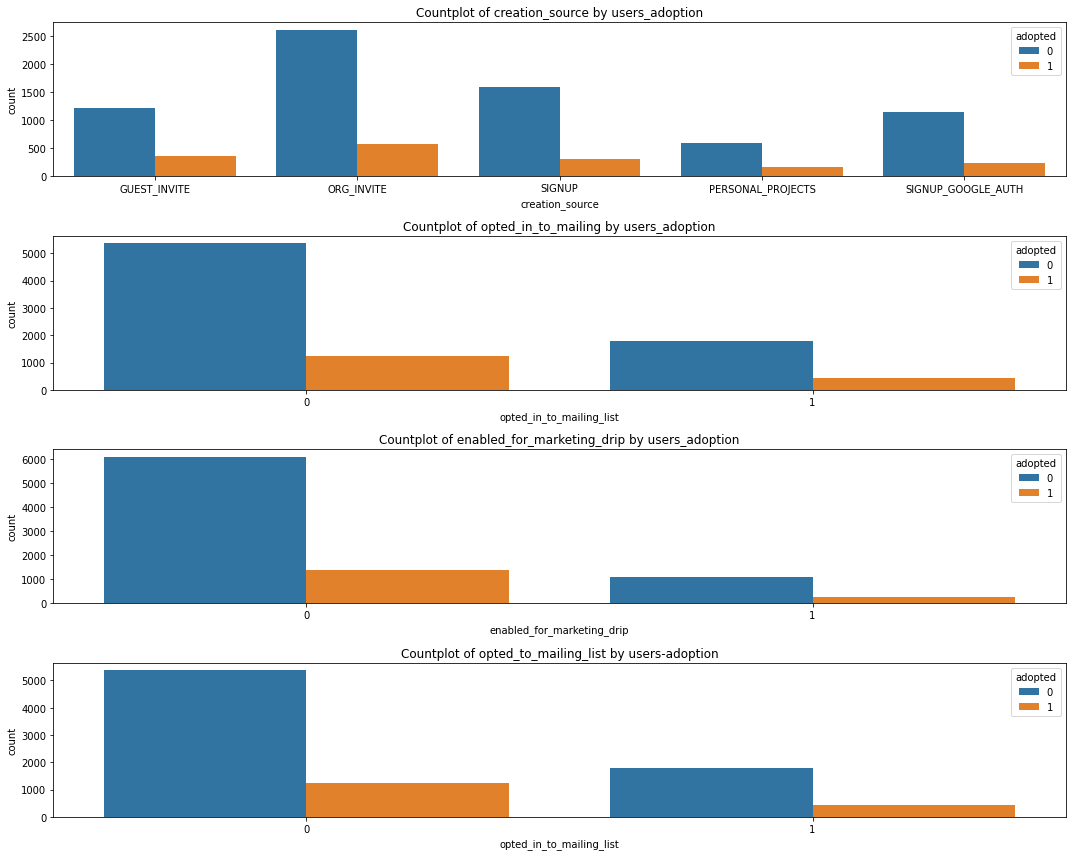

In [20]:
#let's explore the categorical features by our target variable
fig, axs = plt.subplots(4, figsize=(15,12))

axs[0].set_title('Countplot of creation_source by users_adoption')
sns.countplot(data=d_cleaned, x='creation_source', hue='adopted', ax=axs[0])

axs[1].set_title('Countplot of opted_in_to_mailing by users_adoption')
sns.countplot(data=d_cleaned, x='opted_in_to_mailing_list', hue='adopted', ax=axs[1])

axs[2].set_title('Countplot of enabled_for_marketing_drip by users_adoption')
sns.countplot(data=d_cleaned, x='enabled_for_marketing_drip', hue='adopted', ax=axs[2])

axs[3].set_title('Countplot of opted_to_mailing_list by users-adoption')
sns.countplot(data=d_cleaned, x='opted_in_to_mailing_list', hue='adopted', ax=axs[3])

plt.tight_layout()

Text(0.5, 1.0, 'Boxplot of history(in days) of users ')

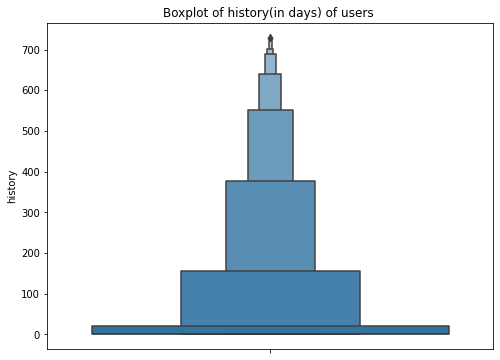

In [21]:
#Let's explore some numerical data

plt.figure(figsize=(8,6))
sns.boxenplot(data=d_cleaned, y='history')
plt.title('Boxplot of history(in days) of users ')

Text(0.5, 1.0, 'Top 20 bar plot of org_id with most users')

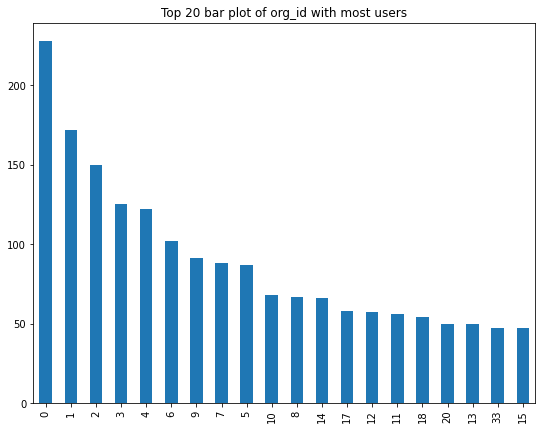

In [22]:
#org_id with most users (top 20)
plt.figure(figsize=(9,7))
d_cleaned['org_id'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 bar plot of org_id with most users')

In [23]:
#users with the most invites

d_cleaned['invited_by_user_id'].value_counts().sort_values(ascending=False).head(20).to_frame().T

,0.0,4612.0,2308.0,11770.0,6808.0,10741.0,3721.0,3261.0,2527.0,4302.0,10628.0,6706.0,4803.0,2354.0,1525.0,730.0,8870.0,6445.0,2771.0,10119.0
invited_by_user_id,4047,10,9,9,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7


Note that the above user_id == 0 are total number of people not invited by any user
<br>
<br>
**Next, Which features are most important at predicting future user adoption?**
In an attempt to answer question, let's build a model to predict 'adopted' feature based of our data

In [24]:
#create dummy variables for our categorical data
d_final = pd.get_dummies(data=d_cleaned, columns=['creation_source'])

In [25]:
#Split data into target feature and independent variables
X = d_final.drop(['object_id', 'adopted'], axis=1)
y = d_final.adopted

In [26]:
#Import an ensemble model and train
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

rf_mod = RandomForestClassifier(n_estimators=20)
rf_mod.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
#Check to ensure no overfitting
rf_mod.score(X_train, y_train)

0.9990284974093264

In [28]:
#predict and evaluate
from sklearn.metrics import classification_report

y_pred = rf_mod.predict(X_test)
print('accuracy score is: ',rf_mod.score(X_test, y_test))
print(classification_report(y_test, y_pred))

accuracy score is:  0.9656214582546279
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2150
           1       0.93      0.88      0.91       497

    accuracy                           0.97      2647
   macro avg       0.95      0.93      0.94      2647
weighted avg       0.97      0.97      0.97      2647



In [29]:
#Lets obtain the feature importance in predicting adoption and sort in descending order

feat_imp = pd.DataFrame(rf_mod.feature_importances_, X.columns)
feat_imp.columns = [ 'Importance_Score']
feat_imp.sort_values('Importance_Score', ascending=False)

,Importance_Score
history,0.873032
org_id,0.068822
invited_by_user_id,0.036708
opted_in_to_mailing_list,0.006058
enabled_for_marketing_drip,0.003329
creation_source_SIGNUP,0.002878
creation_source_GUEST_INVITE,0.002698
creation_source_ORG_INVITE,0.002690
creation_source_SIGNUP_GOOGLE_AUTH,0.001900
creation_source_PERSONAL_PROJECTS,0.001884


**Takeaway**

* The feature **user_history** is the most important feature to predicting adoption. 
Thus, the best approach to user adoption is to encourage existing user to remain and use the apps, probably by incentives.<br>
Future work could be done on what incentives works best. 

* The next two important fearures are **org_id** and **invited_by_user_id**. In other words users are more likely to be adopted users if they belong to certain org_id and if a user invited them. Thus, to get more users adoption, encourage referal incentives, and targeted organizations referals incentives. Again future work could be done to determine what kind of incentives works best.

* Other feature such as **opted_for_mailing_list, enabled_for_marketing_drip, creation_source ** have negligible importance to predicting users_adoption in our work.

